<a href="https://colab.research.google.com/github/mounikaduddukuri/S7/blob/master/s7assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount the drive where we will save stats and loade our libraries from
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:
import numpy as np
import eva4datatransforms

from torchvision import transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
trans = eva4datatransforms.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()

In [0]:
tuple(fillmeans)

(125, 122, 113)

In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


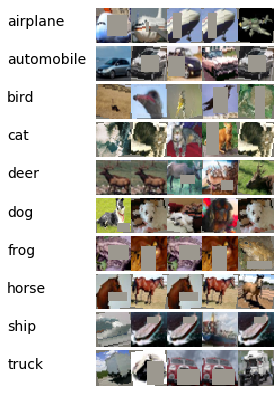

In [0]:
from __future__ import print_function
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
import eva4model4
import torch
model = eva4model4.Cfar10Net4()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           4,608
       BatchNorm2d-9           [-1, 32, 16, 16]              64
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

In [0]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 10
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.228710).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0117, Accuracy: 44.73%; Test set: Average loss: 1.2287, Accuracy: 55.17%
Learning Rate = 0.140186


Validation loss decreased (1.228710 --> 0.993663).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0090, Accuracy: 58.78%; Test set: Average loss: 0.9937, Accuracy: 64.70%
Learning Rate = 0.380371


Epoch: 3, Train set: Average loss: 0.0079, Accuracy: 64.12%; Test set: Average loss: 1.1576, Accuracy: 62.36%
Learning Rate = 0.500000


Validation loss decreased (0.993663 --> 0.824690).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0073, Accuracy: 67.36%; Test set: Average loss: 0.8247, Accuracy: 72.39%
Learning Rate = 0.475118


Validation loss decreased (0.824690 --> 0.771514).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0068, Accuracy: 69.47%; Test set: Average loss: 0.7715, Accuracy: 73.29%
Learning Rate = 0.405648


Validation loss decreased (0.771514 --> 0.701541).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0063, Accuracy: 71.85%; Test set: Average loss: 0.7015, Accuracy: 76.09%
Learning Rate = 0.305351


Validation loss decreased (0.701541 --> 0.649200).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0060, Accuracy: 72.90%; Test set: Average loss: 0.6492, Accuracy: 77.78%
Learning Rate = 0.194091


Validation loss decreased (0.649200 --> 0.588512).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0056, Accuracy: 74.77%; Test set: Average loss: 0.5885, Accuracy: 79.74%
Learning Rate = 0.093905


Validation loss decreased (0.588512 --> 0.535750).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0052, Accuracy: 76.94%; Test set: Average loss: 0.5358, Accuracy: 81.65%
Learning Rate = 0.024635


Validation loss decreased (0.535750 --> 0.526077).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0049, Accuracy: 78.20%; Test set: Average loss: 0.5261, Accuracy: 81.97%
Learning Rate = 0.000002

